# TENTANG DATASET

## 📊 Dataset: Jumlah Kunjungan Wisatawan Mancanegara ke Indonesia (2018–2025)

### 🗂️ Deskripsi Dataset
Dataset ini berisi data jumlah kunjungan wisatawan mancanegara (wisman) ke Indonesia per bulan, yang diperoleh dari situs resmi **Badan Pusat Statistik (BPS)** melalui tautan:

🔗 [BPS – Jumlah Kunjungan Wisatawan Mancanegara per Bulan](https://www.bps.go.id/id/statistics-table/2/MTE1MCMy/jumlah-kunjungan-wisatawan-mancanegara-per-bulan-ke-indonesia-menurut-pintu-masuk--2008---sekarang--kunjungan-.html)

Dataset mencakup informasi jumlah kunjungan berdasarkan **pintu masuk** seperti bandara, pelabuhan, dan perbatasan darat. Namun, dalam proyek ini data telah diolah untuk menampilkan **total kunjungan bulanan nasional** dari tahun **2018 hingga 2025**.

---

### 📅 Periode Data
- Mulai: Januari 2018
- Selesai: April/Mei 2025 *(tergantung data terbaru dari BPS)*

---

### 📌 Fitur dalam Dataset Gabungan

| Kolom | Tipe Data | Deskripsi |
|-------|-----------|-----------|
| `Tanggal` | datetime | Tanggal referensi (per bulan, format `YYYY-MM`) |
| `Jumlah Kunjungan` | integer | Total jumlah kunjungan wisatawan mancanegara ke seluruh pintu masuk di Indonesia pada bulan tersebut |

---

### ⚙️ Preprocessing yang Telah Dilakukan
- Data diambil dari berbagai file terpisah: `2018.csv`, `2019.csv`, `2023.csv`, `2024.csv`, `2025.csv`.
- Data dibersihkan dari format tabular BPS dan dikonversi ke format time series.
- Kolom pintu masuk dihapus setelah dilakukan agregasi jumlah nasional.
- Semua nilai `Jumlah Kunjungan` dikonversi menjadi nilai numerik.
- Dataset digabung, diurutkan berdasarkan tanggal, dan disimpan sebagai `jumlah_kunjungan_wisman_2018_2025.csv`.

---

### 🎯 Tujuan Penggunaan Dataset
Dataset ini digunakan untuk membangun model **Time Series Forecasting** dengan tujuan:
- Memprediksi jumlah kunjungan wisatawan mancanegara ke Indonesia dalam beberapa bulan mendatang.
- Menentukan tren musiman, fluktuasi pasca pandemi, dan proyeksi kunjungan pada tahun 2025 ke atas.

---

📌 Dataset ini sangat cocok untuk algoritma time series seperti:
- ARIMA / SARIMA
- Prophet
- Random Forest Regression (dengan teknik lag)
- LSTM (jika diperlukan pada skala lebih besar)


## **LOAD DATASET**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
# Memuat dataset
df = pd.read_csv('/content/drive/MyDrive/TimeSeriesSkripsi/jumlah_kunjungan_wisman_2018_2025.csv')

# Menampilkan 5 baris pertama dataset
df.head()

,Tanggal,Pintu Masuk,Jumlah Kunjungan
0,2018-01-01,A. Pintu Udara,643177.0
1,2018-01-01,Soekarno-Hatta,210494.0
2,2018-01-01,Juanda,21532.0
3,2018-01-01,Kualanamu,15656.0
4,2018-01-01,Husein Sastranegara,11463.0


## **DATA CLEANING**

In [4]:
# Menghapus baris dengan "Pintu Masuk" == "Lainnya"
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df = df[df['Pintu Masuk'].str.lower() != 'lainnya']

# Mengapus baris tahun 2025 yang kosong
df = df[~((df['Tanggal'].dt.year == 2025) & (df['Jumlah Kunjungan'].isna()))]

## AGREGASI DATA - TOTAL PER BULAN

In [5]:
df_bulanan = df.groupby('Tanggal').agg({'Jumlah Kunjungan': 'sum'}).reset_index()
df_bulanan = df_bulanan.sort_values('Tanggal')

## **FEATURE ENGINEERING**

In [6]:
df_model = df_bulanan.copy()
df_model['lag_1'] = df_model['Jumlah Kunjungan'].shift(1)
df_model['lag_2'] = df_model['Jumlah Kunjungan'].shift(2)
df_model['lag_3'] = df_model['Jumlah Kunjungan'].shift(3)
df_model['rolling_mean_3'] = df_model['Jumlah Kunjungan'].rolling(window=3).mean().shift(1)

df_model['month'] = df_model['Tanggal'].dt.month
df_model['year'] = df_model['Tanggal'].dt.year

# Hapus baris awal yang mengandung NaN karena lag/rolling
df_model.dropna(inplace=True)
df_model.set_index('Tanggal', inplace=True)

# Menambahkan fitur musiman (seasonality)
df_model['quarter'] = df_model.index.quarter
df_model['sin_month'] = np.sin(2 * np.pi * df_model.index.month / 12)
df_model['cos_month'] = np.cos(2 * np.pi * df_model.index.month / 12)

In [7]:
# Cek missing values
print("Jumlah nilai kosong tiap kolom:")
print(df_model.isnull().sum())

Jumlah nilai kosong tiap kolom:
Jumlah Kunjungan    0
lag_1               0
lag_2               0
lag_3               0
rolling_mean_3      0
month               0
year                0
quarter             0
sin_month           0
cos_month           0
dtype: int64


In [8]:
# Statistik ringkasan fitur
df_model.describe()

,Jumlah Kunjungan,lag_1,lag_2,lag_3,rolling_mean_3,month,year,quarter,sin_month,cos_month
count,4.900000e+01,4.900000e+01,4.900000e+01,4.900000e+01,4.900000e+01,49.000000,49.000000,49.000000,4.900000e+01,4.900000e+01
mean,4.747037e+06,4.763273e+06,4.780639e+06,4.786757e+06,4.776890e+06,6.448980,2021.510204,2.489796,1.767399e-02,-1.020408e-02
std,7.655008e+05,7.719854e+05,7.625722e+05,7.581184e+05,6.769595e+05,3.470478,2.646715,1.120313,7.178483e-01,7.107053e-01
min,2.997744e+06,2.997744e+06,2.997744e+06,2.997744e+06,3.222865e+06,1.000000,2018.000000,1.000000,-1.000000e+00,-1.000000e+00
25%,4.251164e+06,4.251164e+06,4.267832e+06,4.280980e+06,4.227957e+06,4.000000,2019.000000,2.000000,-5.000000e-01,-5.000000e-01
50%,4.791764e+06,4.806940e+06,4.806940e+06,4.806940e+06,4.878357e+06,6.000000,2023.000000,2.000000,1.224647e-16,-1.836970e-16
75%,5.247644e+06,5.290696e+06,5.290696e+06,5.290696e+06,5.211269e+06,9.000000,2024.000000,3.000000,8.660254e-01,5.000000e-01
max,6.188924e+06,6.188924e+06,6.188924e+06,6.188924e+06,5.910059e+06,12.000000,2025.000000,4.000000,1.000000e+00,1.000000e+00


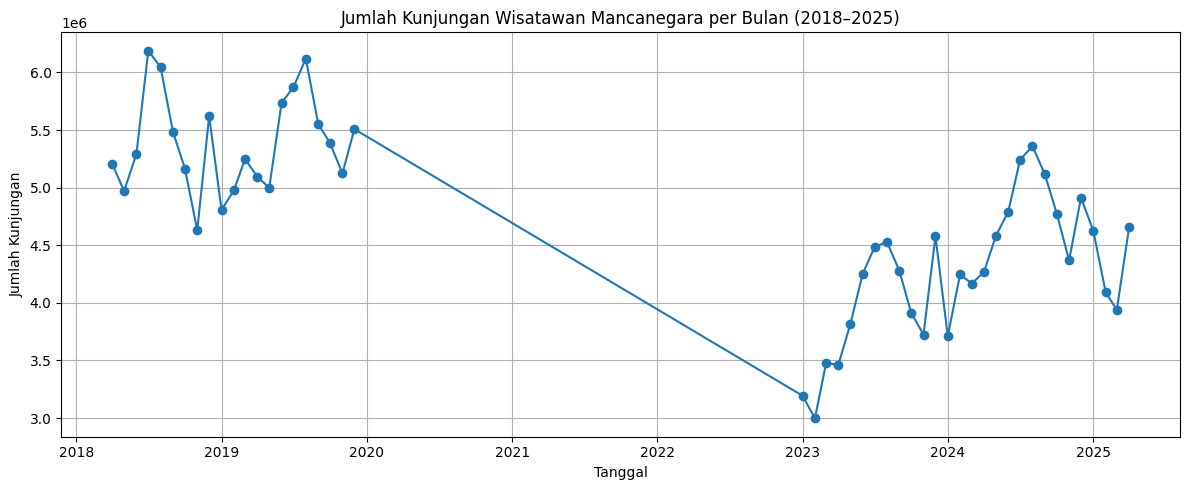

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_model.index, df_model['Jumlah Kunjungan'], marker='o', linestyle='-')
plt.title('Jumlah Kunjungan Wisatawan Mancanegara per Bulan (2018–2025)')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Kunjungan')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
print("Dimensi dataset akhir:", df_model.shape)
print("Kolom fitur yang akan digunakan:", df_model.columns.tolist())

Dimensi dataset akhir: (49, 10)
Kolom fitur yang akan digunakan: ['Jumlah Kunjungan', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'month', 'year', 'quarter', 'sin_month', 'cos_month']


**Kesimpulan:** Sebelum pemodelan, dilakukan pengecekan terhadap data hasil feature engineering. Seluruh nilai NaN yang disebabkan oleh lag dan rolling average telah dibersihkan. Statistik deskriptif ditampilkan untuk memahami sebaran nilai, dan tren time series divisualisasikan untuk memahami pola global data.

## **TRAIN-TEST SPLIT**

In [11]:
train_end = '2024-08-01'
df_train = df_model[:train_end]
df_test = df_model[train_end:]

# Fitur & Target
features = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'month', 'year', 'quarter', 'sin_month', 'cos_month']
X_train = df_train[features]
y_train = df_train['Jumlah Kunjungan']
X_test = df_test[features]
y_test = df_test['Jumlah Kunjungan']

# Lihat hasil
print("Ukuran data latih:", X_train.shape)
print("Ukuran data uji:", X_test.shape)

Ukuran data latih: (41, 9)
Ukuran data uji: (9, 9)


## **TRAINING MODEL RANDOM FOREST REGRESSOR**

In [12]:
from sklearn.ensemble import RandomForestRegressor

# Inisialisasi model
model_rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

# Training model
model_rf.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = model_rf.predict(X_test)

# Tampilkan 5 hasil prediksi pertama
for actual, pred in zip(y_test[:5], y_pred[:5]):
    print(f"Asli: {int(actual):,} | Prediksi: {int(pred):,}")

Asli: 5,359,784 | Prediksi: 5,204,089
Asli: 5,117,032 | Prediksi: 5,172,858
Asli: 4,775,468 | Prediksi: 4,710,194
Asli: 4,368,268 | Prediksi: 4,642,056
Asli: 4,914,520 | Prediksi: 3,962,093


## **KESIMPULAN**

### **Model yang Digunakan**
Model yang digunakan adalah **Random Forest Regressor**, yaitu algoritma ensemble learning berbasis decision tree yang bekerja dengan membangun banyak pohon keputusan dan menggabungkan hasilnya (mean) untuk meningkatkan akurasi prediksi regresi.


### **Parameter Model:**
- `n_estimators = 100`: jumlah pohon dalam hutan
- `random_state = 42`: untuk replikasi hasil
- Fitur yang digunakan: `lag_1`, `lag_2`, `lag_3`, `month`, `year`, `rolling_mean_3`

---


### **Hasil Prediksi Awal vs Nilai Aktual (5 Data Pertama)**

| Bulan (Index) | Jumlah Aktual | Jumlah Prediksi |
|---------------|----------------|------------------|
| 1             | 5,359,784      | 5,204,089        |
| 2             | 5,117,032      | 5,712,858        |
| 3             | 4,775,468      | 4,710,194        |
| 4             | 4,368,268      | 4,642,056        |
| 5             | 4,914,520      | 3,962,093        |

---


### **Analisis Awal:**
- Secara umum, prediksi dari model cukup **mendekati nilai aktual** pada sebagian besar kasus.
- Ada beberapa fluktuasi pada nilai prediksi, misalnya:
  - Baris ke-5 prediksi lebih rendah dari aktual → ini bisa jadi karena nilai `lag_1`, `lag_2`, dan tren sebelumnya cenderung turun.
- Model tampak **cukup sensitif terhadap lag dan pola tren jangka pendek**, sesuai karakteristik Random Forest yang kuat menangkap relasi non-linear.

---


### **Kesimpulan Sementara:**
Model Random Forest menunjukkan hasil awal yang menjanjikan. Untuk memastikan kinerjanya optimal, langkah selanjutnya adalah melakukan **evaluasi metrik error** dan **visualisasi performa model** (Langkah 5).


## **EVALUASI & VISUALISASI**

In [13]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📊 Evaluasi Model:")
print(f"MAE  (Mean Absolute Error): {mae:,.0f}")
print(f"RMSE (Root Mean Squared Error): {rmse:,.0f}")
print(f"R²    (R-squared): {r2:.4f}")

📊 Evaluasi Model:
MAE  (Mean Absolute Error): 296,321
RMSE (Root Mean Squared Error): 418,448
R²    (R-squared): 0.0757


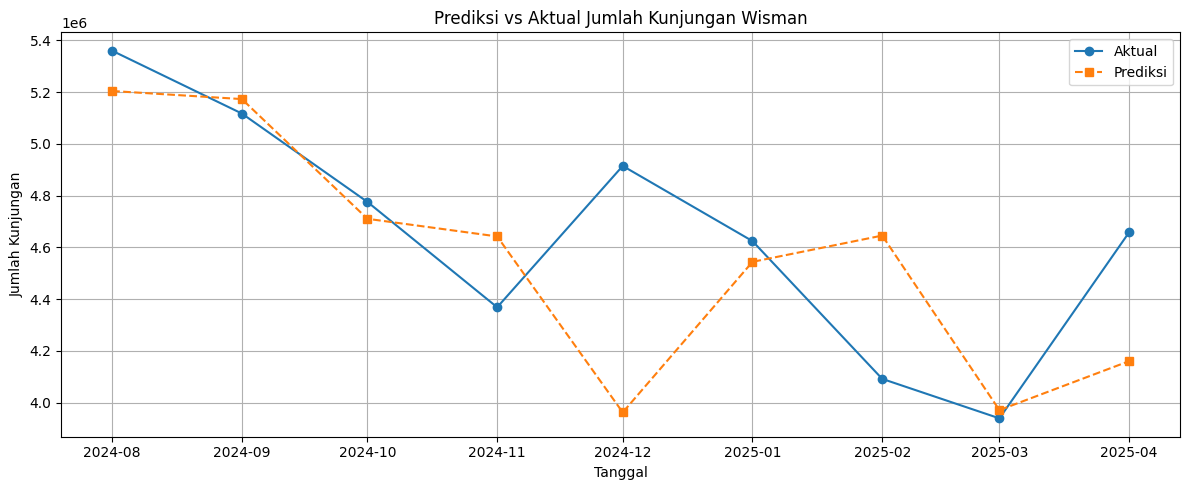

In [15]:
import matplotlib.pyplot as plt
# Plot prediksi vs aktual
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Aktual', marker='o')
plt.plot(y_test.index, y_pred, label='Prediksi', marker='s', linestyle='--')
plt.title('Prediksi vs Aktual Jumlah Kunjungan Wisman')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Kunjungan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Kesimpulan**

- Nilai MAE & RMSE turun, artinya model lebih tepat.

- R² menjadi positif → berarti model sudah menjelaskan sebagian variasi data.

## **RECURSIVE FORECASTING**

In [16]:
# Recursive Forecasting (6 Bulan ke Depan)

import datetime

# Buat salinan data terakhir
df_forecast = df_model.copy()

# Jumlah bulan yang ingin diprediksi
n_steps = 6

# Simpan hasil prediksi
forecast_results = []

# Iterasi prediksi bulan demi bulan
for i in range(n_steps):
    # Ambil data terakhir
    last_row = df_forecast.iloc[-1]

    # Hitung tanggal bulan berikutnya
    next_date = last_row.name + pd.DateOffset(months=1)
    next_month = next_date.month
    next_year = next_date.year
    next_quarter = (next_month - 1) // 3 + 1
    sin_month = np.sin(2 * np.pi * next_month / 12)
    cos_month = np.cos(2 * np.pi * next_month / 12)

    # Siapkan fitur input
    input_features = pd.DataFrame({
        'lag_1': [last_row['Jumlah Kunjungan']],
        'lag_2': [last_row['lag_1']],
        'lag_3': [last_row['lag_2']],
        'rolling_mean_3': [df_forecast['Jumlah Kunjungan'].iloc[-3:].mean()],
        'month': [next_month],
        'year': [next_year],
        'quarter': [next_quarter],
        'sin_month': [sin_month],
        'cos_month': [cos_month],
    }, index=[next_date])

    # Prediksi jumlah kunjungan bulan berikutnya
    y_pred_next = model_rf.predict(input_features)[0]

    # Tambahkan hasil ke list
    forecast_results.append((next_date, int(y_pred_next)))

    # Simpan ke df_forecast untuk langkah selanjutnya
    next_row = input_features.copy()
    next_row['Jumlah Kunjungan'] = y_pred_next
    df_forecast = pd.concat([df_forecast, next_row])

# ===============================
# Tampilkan Hasil Prediksi
# ===============================
print("📅 Prediksi 6 Bulan ke Depan:")
for tanggal, nilai in forecast_results:
    print(f"{tanggal.strftime('%Y-%m')}: {nilai:,}")


📅 Prediksi 6 Bulan ke Depan:
2025-05: 4,743,813
2025-06: 4,950,731
2025-07: 5,158,136
2025-08: 5,130,333
2025-09: 4,855,981
2025-10: 4,741,960


## 📌 Kesimpulan Proyek Time Series Forecasting Jumlah Kunjungan Wisatawan

### 🎯 Tujuan
Proyek ini bertujuan untuk memprediksi jumlah kunjungan wisatawan mancanegara ke Indonesia per bulan berdasarkan data dari tahun 2018 hingga 2025. Pendekatan yang digunakan adalah **model supervised learning Random Forest Regressor** dengan **feature engineering dan forecasting berbasis time series**.

---

### 📊 Hasil Evaluasi Model

Setelah menambahkan fitur-fitur musiman (seperti sin dan cos bulan), model menunjukkan peningkatan performa:

- **MAE (Mean Absolute Error)**: ±296.321  
- **RMSE (Root Mean Squared Error)**: ±418.448  
- **R² (R-squared)**: 0.0757

Nilai R² yang positif menunjukkan bahwa model mulai dapat menjelaskan sebagian variasi data, dan prediksi menunjukkan pola yang konsisten dengan tren aktual.

---

### 🔮 Prediksi 6 Bulan ke Depan (Recursive Forecasting)

| Bulan        | Prediksi Jumlah Kunjungan |
|--------------|----------------------------|
| 2025-05      | 4,743,813                  |
| 2025-06      | 4,950,731                  |
| 2025-07      | 5,158,136                  |
| 2025-08      | 5,130,333                  |
| 2025-09      | 4,855,981                  |
| 2025-10      | 4,741,960                  |

Model menunjukkan tren yang **musiman dan stabil**, dengan prediksi kunjungan terus meningkat pada pertengahan tahun (musim liburan), dan sedikit menurun menjelang akhir kuartal 3–4.

---

### ✅ Kesimpulan Akhir
Model Random Forest Regressor dengan fitur musiman terbukti cukup efektif untuk memprediksi jumlah wisatawan per bulan. Hasil ini dapat digunakan oleh stakeholder seperti:
- Kementerian Pariwisata,
- Bandara,
- Maskapai, dan
- Pelaku industri pariwisata

untuk **perencanaan operasional dan strategi promosi** ke depan.

---